# Advantage Actor Critic (A2C) Implementation on CartPole
http://inoryy.com/post/tensorflow2-deep-reinforcement-learning/#advantage-actor-critic-with-tensorflow-2-1
https://github.com/inoryy/tensorflow2-deep-reinforcement-learning/blob/master/actor-critic-agent-with-tensorflow2.ipynb

In [30]:
import gym
import logging
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.keras.layers as kl
import tensorflow.keras.losses as kls
import tensorflow.keras.optimizers as ko

In [31]:
class ProbabilityDistribution(tf.keras.Model):
    def call(self, logits, **kwargs):
        # Sample a random categorical action from the given logits.
        return tf.squeeze(tf.random.categorical(logits, 1), axis=-1)


class Model(tf.keras.Model):
    def __init__(self, num_actions):
        super().__init__('mlp_policy')
        # Note: no tf.get_variable(), just simple Keras API!
        self.hidden1 = kl.Dense(128, activation='relu')
        self.hidden2 = kl.Dense(128, activation='relu')
        self.value = kl.Dense(1, name='value')
        # Logits are unnormalized log probabilities.
        self.logits = kl.Dense(num_actions, name='policy_logits')
        self.dist = ProbabilityDistribution()

    def call(self, inputs, **kwargs):
        # Inputs is a numpy array, convert to a tensor.
        x = tf.convert_to_tensor(inputs)
        # Separate hidden layers from the same input tensor.
        hidden_logs = self.hidden1(x)
        hidden_vals = self.hidden2(x)
        return self.logits(hidden_logs), self.value(hidden_vals)

    def action_value(self, obs):
        # Executes `call()` under the hood.
        logits, value = self.predict_on_batch(obs)
        action = self.dist.predict_on_batch(logits)
        # Another way to sample actions:
        #   action = tf.random.categorical(logits, 1)
        # Will become clearer later why we don't use it.
        return np.squeeze(action, axis=-1), np.squeeze(value, axis=-1)


In [32]:
# Verify everything works by sampling a single action.
env = gym.make('CartPole-v0')
model = Model(num_actions=env.action_space.n)
model.action_value(env.reset()[None, :])

(array(1), array([-0.00692584], dtype=float32))

In [36]:
class A2CAgent:
    def __init__(self, model, lr=7e-3, gamma=0.99, value_c=0.5, entropy_c=1e-4):
        # `gamma` is the discount factor; coefficients are used for the loss terms.
        self.gamma = gamma
        self.value_c = value_c
        self.entropy_c = entropy_c

        self.model = model
        self.model.compile(
        optimizer=ko.RMSprop(lr=lr),
        # Define separate losses for policy logits and value estimate.
        loss=[self._logits_loss, self._value_loss])

    def train(self, env, batch_sz=64, updates=250):
        # Storage helpers for a single batch of data.
        actions = np.empty((batch_sz,), dtype=np.int32)
        rewards, dones, values = np.empty((3, batch_sz))
        observations = np.empty((batch_sz,) + env.observation_space.shape)
        # Training loop: collect samples, send to optimizer, repeat updates times.
        ep_rewards = [0.0]
        next_obs = env.reset()
        for update in range(updates):
            for step in range(batch_sz):
                observations[step] = next_obs.copy()
                actions[step], values[step] = self.model.action_value(next_obs[None, :])
                next_obs, rewards[step], dones[step], _ = env.step(actions[step])

                ep_rewards[-1] += rewards[step]
                if dones[step]:
                    ep_rewards.append(0.0)
                    next_obs = env.reset()
                    logging.info("Episode: %03d, Reward: %03d" % (len(ep_rewards) - 1, ep_rewards[-2]))

            _, next_value = self.model.action_value(next_obs[None, :])
            returns, advs = self._returns_advantages(rewards, dones, values, next_value)
            # A trick to input actions and advantages through same API.
            acts_and_advs = np.concatenate([actions[:, None], advs[:, None]], axis=-1)
            # Performs a full training step on the collected batch.
            # Note: no need to mess around with gradients, Keras API handles it.
            losses = self.model.train_on_batch(observations, [acts_and_advs, returns])
            logging.debug("[%d/%d] Losses: %s" % (update + 1, updates, losses))

        return ep_rewards

    def test(self, env, render=False):
        obs, done, ep_reward = env.reset(), False, 0
        while not done:
            action, _ = self.model.action_value(obs[None, :])
            obs, reward, done, _ = env.step(action)
            ep_reward += reward
            if render:
                env.render()
        return ep_reward

    def _returns_advantages(self, rewards, dones, values, next_value):
        # `next_value` is the bootstrap value estimate of the future state (critic).
        returns = np.append(np.zeros_like(rewards), next_value, axis=-1)
        # Returns are calculated as discounted sum of future rewards.
        for t in reversed(range(rewards.shape[0])):
            returns[t] = rewards[t] + self.gamma * returns[t + 1] * (1 - dones[t])
        returns = returns[:-1]
        # Advantages are equal to returns - baseline (value estimates in our case).
        advantages = returns - values
        return returns, advantages

    def _value_loss(self, returns, value):
        # Value loss is typically MSE between value estimates and returns.
        return self.value_c * kls.mean_squared_error(returns, value)

    def _logits_loss(self, actions_and_advantages, logits):
        # A trick to input actions and advantages through the same API.
        actions, advantages = tf.split(actions_and_advantages, 2, axis=-1)
        # Sparse categorical CE loss obj that supports sample_weight arg on `call()`.
        # `from_logits` argument ensures transformation into normalized probabilities.
        weighted_sparse_ce = kls.SparseCategoricalCrossentropy(from_logits=True)
        # Policy loss is defined by policy gradients, weighted by advantages.
        # Note: we only calculate the loss on the actions we've actually taken.
        actions = tf.cast(actions, tf.int32)
        policy_loss = weighted_sparse_ce(actions, logits, sample_weight=advantages)
        # Entropy loss can be calculated as cross-entropy over itself.
        probs = tf.nn.softmax(logits)
        entropy_loss = kls.categorical_crossentropy(probs, probs)
        # We want to minimize policy and maximize entropy losses.
        # Here signs are flipped because the optimizer minimizes.
        return policy_loss - self.entropy_c * entropy_loss

In [37]:
# Verify everything works with random weights.
agent = A2CAgent(model)
rewards_sum = agent.test(env)
print("Total Episode Reward: %d out of 200" % agent.test(env))

Total Episode Reward: 15 out of 200


INFO:root:Episode: 001, Reward: 021
INFO:root:Episode: 002, Reward: 019
INFO:root:Episode: 003, Reward: 064
INFO:root:Episode: 004, Reward: 023
INFO:root:Episode: 005, Reward: 062
INFO:root:Episode: 006, Reward: 047
INFO:root:Episode: 007, Reward: 047
INFO:root:Episode: 008, Reward: 061
INFO:root:Episode: 009, Reward: 041
INFO:root:Episode: 010, Reward: 047
INFO:root:Episode: 011, Reward: 075
INFO:root:Episode: 012, Reward: 053
INFO:root:Episode: 013, Reward: 081
INFO:root:Episode: 014, Reward: 107
INFO:root:Episode: 015, Reward: 032
INFO:root:Episode: 016, Reward: 086
INFO:root:Episode: 017, Reward: 037
INFO:root:Episode: 018, Reward: 044
INFO:root:Episode: 019, Reward: 077
INFO:root:Episode: 020, Reward: 066
INFO:root:Episode: 021, Reward: 055
INFO:root:Episode: 022, Reward: 073
INFO:root:Episode: 023, Reward: 028
INFO:root:Episode: 024, Reward: 040
INFO:root:Episode: 025, Reward: 061
INFO:root:Episode: 026, Reward: 093
INFO:root:Episode: 027, Reward: 073
INFO:root:Episode: 028, Rewa

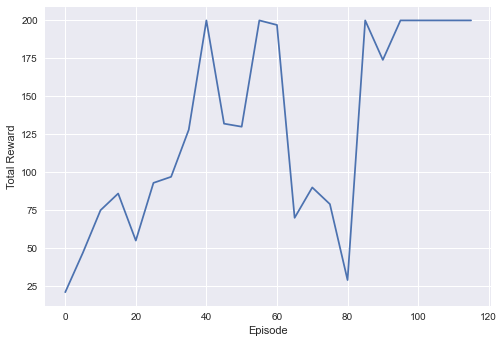

In [38]:
# set to logging.WARNING to disable logs or logging.DEBUG to see losses as well
logging.getLogger().setLevel(logging.INFO)

model = Model(num_actions=env.action_space.n)
agent = A2CAgent(model)

rewards_history = agent.train(env)
print("Finished training! Testing...")
print("Total Episode Reward: %d out of 200" % agent.test(env))

plt.style.use('seaborn')
plt.plot(np.arange(0, len(rewards_history), 5), rewards_history[::5])
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.show()